<div class="span5 alert alert-info">
<h3>Artist Identication from Arts</h3>
<br/>
<b>Introduction:</b> Artist identification of fine art paintings is a challenging problem primarily handled by art historians with extensive training and expertise. Artist identification is the task of identifying the artist ofa painting given no other information about it. This is an important requirement for cataloguing art, especially as art is increasingly digitized. One of the most comprehensive datasets, Wikiart, has around 150,000 artworks by 2,500 artists [30]. Artsy has a growing collection with the aim of making all art easily available and accessible online [1]. As these collections grow, it becomes increasingly important to be able to efficiently label and identify newly digitized art pieces. A reliable way to identify artists is not only useful for labeling art pieces but also for identifying forgeries, another important art historical problem.
<br/>
<b>Dataset Overview:</b> In order to train a CNN to identify artists, i first obtain a large dataset of art compiled by Kaggle that is based on the WikiArt dataset [13]. This dataset contains roughly 100,000 paintings by 2,300 artists spanning a variety of time periods and styles.The images vary widely in size and shape. Every image is labeled with its artist in a separate .csv file.
</div>

In [1]:
#Importing all the libraries.
import pickle
import os
from os import listdir
from PIL import Image as PImage
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
from sklearn import svm
from scipy.misc import imresize
import patoolib
import os, sys, tarfile
import cv2    #opencv for image/video manipulation

In [2]:
df = pd.read_csv('all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [3]:
df.shape

(103250, 12)

<div class="span5 alert alert-info">
<b>Art selection:</b> The vast majority of artists in the full dataset have fewer than 50 paintings, so in order to ensure sufficient sample sizes for training networks we use only the artists with 300 or more paintings in the dataset. Therefore, our dataset consists of 300 paintings per artist from 50 artists (about 22,629 total paintings) from a wide variety of styles and time periods.
</div>

In [3]:
#Selecting only top 3 artists and their paintings.

In [4]:
df=df[(df['artist']=='Albrecht Durer')|(df['artist']=='Pierre-Auguste Renoir')|(df['artist']=='Gustave Dore')]

In [5]:
df.shape

(1500, 12)

In [141]:
#Creating list of rest of artists those painting will be removed from my dataset.
'''d2=pd.Series(df['artist'].value_counts().tail(2269).index)
df_remove = pd.DataFrame(data=d2,columns=['artist'],index=range(len(d2)))
df1 = df.merge(df_remove)'''

In [6]:
df['artist'].value_counts()

Gustave Dore             500
Albrecht Durer           500
Pierre-Auguste Renoir    500
Name: artist, dtype: int64

In [8]:
df.head()

,new_filename,new_file_name
29809,100006.jpg,Pierre-Auguste_Renoir_100006.jpg
32254,100046.jpg,Albrecht_Durer_100046.jpg
32450,100114.jpg,Gustave_Dore_100114.jpg
48924,100116.jpg,Gustave_Dore_100116.jpg
25779,100159.jpg,Pierre-Auguste_Renoir_100159.jpg


In [7]:
# This step will append corresponding artist name for each and very paintings 
df = df[['artist', 'new_filename']].sort_values(by='new_filename')
#Creating new columns with updaed file names
new_file = df['artist'].apply(lambda x: (x.replace(" ", "_") + "_"))
df['new_file'] = new_file
df['new_file_name'] = df['new_file'] + df['new_filename']
df = df[['new_filename', 'new_file_name']]

<div class="span5 alert alert-info">
<b></b> So we have 1500 Paintings for 3 artists.
</div>

In [7]:
#PImage.open('Selected_Data/images/William_Merritt_Chase_9803.jpg')
image=cv2.imread('Selected_Data/images/Zinaida_Serebriakova_102964.jpg')
#print(image.T)
cv2.imshow('102964.jpg', image)
#r,g,b = cv2.split(image)
#res=cv2.resize(image,(250,250))
#gray_image = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
#cv2.imshow('gray',gray_image)

#The intensity of red is 166, green is 175 and blue is 204!

In [42]:
crop=image[200:500, 600:900]
cv2.imshow('crop',crop)

# GLCM feature extraction to reduce dimentionality

Grey Level Co-occurence matrix:  GLCM considers the spatial relationship of pixels and characterizes the
texture of an image by calculating how often pairs of pixel with specific values
and spatial relationships occur in an image. Once the GLCM is constructed,
statistical measures are extracted from the matrix.

In [16]:
import cv2
import skimage.feature as sk
import mahotas.features as feature

In [9]:
img=cv2.imread('Selected_Data/images/William_Merritt_Chase_9803.jpg',0)
img

array([[51, 50, 48, ..., 50, 53, 53],
       [60, 54, 48, ..., 42, 44, 44],
       [54, 45, 37, ..., 34, 35, 36],
       ..., 
       [92, 85, 59, ..., 35, 34, 36],
       [76, 83, 60, ..., 39, 36, 36],
       [79, 74, 75, ..., 42, 35, 42]], dtype=uint8)

In [10]:
cv2.imshow('pic',img)

In [4]:
img.shape

(337, 256)

In [5]:
glcm=sk.greycomatrix(image=img,distances=[1],angles=[0,np.pi/4,np.pi/2,3*np.pi/4])

In [6]:
glcm[:,:,0]

array([[[ 1,  5,  3,  0],
        [ 0,  1,  0,  0],
        [ 1,  0,  2,  0],
        ..., 
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  1,  0],
        ..., 
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       [[ 1,  0,  1,  1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  1],
        ..., 
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       ..., 
       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ..., 
        [ 2,  3,  5,  1],
        [ 5,  3,  1,  4],
        [18,  8,  7,  4]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ..., 
        [ 3,  4,  1,  0],
        [ 5,  2,  3,  5],
        [10, 11, 10,  6]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ..., 
        [ 7,  7,  7,  9],
        [

In [7]:
F14 = feature.haralick(img).mean(0)

In [8]:
F14

array([  4.86743530e-04,   3.40974930e+02,   9.62950718e-01,
         4.60097897e+03,   1.61278887e-01,   1.54637113e+02,
         1.80629409e+04,   8.17469155e+00,   1.25522912e+01,
         2.08094516e-04,   4.80212330e+00,  -2.59818659e-01,
         9.87685703e-01])

In [11]:
def glcm(img):
    F14 = feature.haralick(img).mean(0)
    return F14
    

# Local Binary Pattern(LBP) Feature Extraction for reduction of dimentions

"To calculate the LBP value for a pixel in the grayscale image,
we compare the central pixel value with the neighbouring pixel values. We
can start from any neighbouring pixel and then we can transverse either in
clockwise or anti-clockwise direction but we must use the same order for all
the pixels. Since there are 8 neighbouring pixels – for each pixel, we will
perform 8 comparisons. The results of the comparisons are stored in a 8-bit
binary array.
If the current pixel value is greater or equal to the neighbouring pixel
value, the corresponding bit in the binary array is set to 1 else if the current
pixel value is less than the neighbouring pixel value, the corresponding bit
in the binary array is set to 0."

# Local Directional Pattern(LDP) Feature Extraction for dimention reduction

The local binary pattern (LBP) operator depends on the change of the intensity around the pixel to encode the micro-level information of spot, edges and other local features in the image (Jabid et al., 2010a). The gradient is known to be more stable than the gray level; that is why some researches have replaced the intensity value at a pixel position with its gradient magnitude and calculated the LBP (Ferrer et al., 2010). The local directional pattern (LDP) was proposed by Jabid et al. (2010b) to resolve the problem with LBP, mentioned earlier. Since the LBP depends on the neighboring pixels’ intensity which makes it unstable. Instead, LDP considers the edge response value in different direction. LDP features are based on eight bit binary codes assigned to each pixel of an input image.

<div class="span5 alert alert-info">
<h3>Support Vector Machine(SVM) for Image Classification</h3>
<br/>
<b>Overview:</b> Our goal is to evaluate the accuracy of a performant classifier such as Support Vector Machine on
object recognition and image classification.
<b>Introduction:</b>The general framework to measure the accuracy of a SVM on a given database is composed of the
following stages :

<ol>
<li> Preprocessing of the images.
<li> Separation of the images in training and test sets
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

</div>

# Transforming the paintings 

So now we have 22629 images with labels. Next we need to put these images into a format suitable for analysis.

One way to represent images in a numerical format is to convert each image to a series of RGB pixels. For example, if we had a 300x150 px image, we'd convert it to a series of 45,000 RGB pixels. We could also explore other numerical measures like hue and saturation, but let's keep it simple for now.

we flatten the images using the flatten_image function, so each is represented as a row in a 2D array.

In [9]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (233, 233)
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    #img = PImage.open(filename)
    img = cv2.imread(filename,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if verbose==True:
        print ("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))
    #img = img.resize(STANDARD_SIZE)
    img=cv2.resize(img, STANDARD_SIZE)
    #img = list(img.getdata())
    #img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    #print(img.shape[0])
    #print(img.shape[1])
    #print(img.shape)
    img_wide = img.reshape(1, s)
    #print(img_wide[0])
    return img_wide[0]

In [24]:
#Checking one image

filename='images/Pierre-Auguste_Renoir_99721.jpg'
img_gray=img_to_matrix(filename, verbose=True)
print("Gray Scale Image"  + str(img_gray))
#glcimg=glcm(img_gray)
#print('glc image' + str(glcimg))
img=flatten_image(img_gray)
print("Flatten Image" + str(img))
#img.size
#test_imgs.shape
#print(img)
#cv2.imshow('show',glcimg)

changing size from 83456 to (233, 233)
Gray Scale Image[[129 164 150 ..., 192 197 206]
 [133 163 150 ..., 170 165 184]
 [114 152 181 ..., 185 166 178]
 ..., 
 [103 125 125 ..., 132 147 168]
 [104 138  95 ..., 140 158 181]
 [110 135  98 ..., 158 175 196]]
Flatten Image[129 164 150 ..., 158 175 196]


# Normalize the data

We need to normalize the images so they're in the same shape. To do that, we resize each observation to 233X233 px.

In [10]:
#Nomalize the data

img_dir = "images_3artists/"
images = [img_dir + f for f in os.listdir(img_dir)]

data = []
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    #img = glcm(img)
    data.append(img)

data = np.array(data)
data

array([[184, 187, 187, ...,  92,  91,  92],
       [  0,   0,   0, ...,  74,  54,  58],
       [245, 244, 245, ..., 254, 254, 247],
       ..., 
       [142, 143, 130, ...,  90,  90, 111],
       [ 44,  89,  58, ...,  60,  51,  81],
       [129, 164, 150, ..., 158, 175, 196]], dtype=uint8)

In [11]:
data.shape

(1500, 54289)

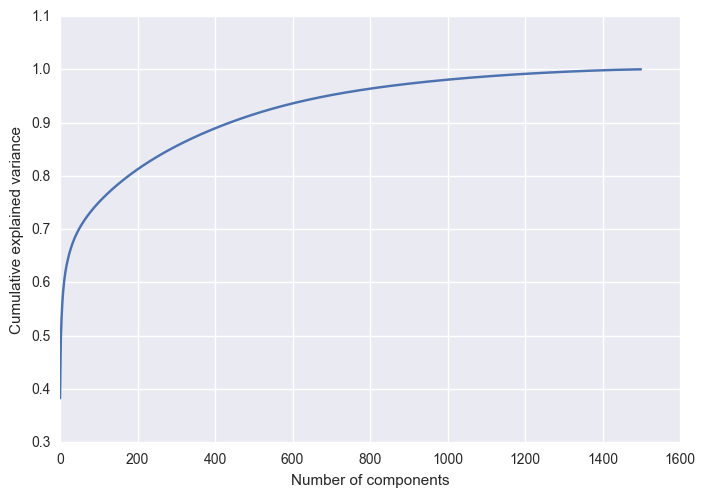

In [12]:
from sklearn.decomposition import PCA

pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlim(0,200,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [13]:
#Since 600 components can explain more than 96% of the variance, we choose the number of the components to be 100
sklearn_pca=PCA(n_components=600)
X = sklearn_pca.fit_transform(data)

In [14]:
X.shape

(1500, 600)

In [22]:
'''data_df = pd.DataFrame(data)
data_df.to_csv('Selected_Data/inputdata.csv')'''

Creating Label array

In [15]:
test_images = pd.DataFrame(next(os.walk('images_3artists'))[2], columns=['new_filename'])
test_images = test_images.sort_values(by='new_filename')

In [16]:
test_images.shape

(1500, 1)

In [17]:
test_images.tail()

,new_filename
1495,Pierre-Auguste_Renoir_99063.jpg
1496,Pierre-Auguste_Renoir_99125.jpg
1497,Pierre-Auguste_Renoir_99187.jpg
1498,Pierre-Auguste_Renoir_99647.jpg
1499,Pierre-Auguste_Renoir_99721.jpg


In [18]:
test_images = test_images['new_filename'].apply(lambda x: x.replace(x.split('_')[-1],''))

In [19]:
test_images = test_images.apply(lambda x: x.replace('_', ' '))

In [20]:
test_images=test_images.ravel()
test_images.shape

(1500,)

In [21]:
test_images

array(['Albrecht Durer ', 'Albrecht Durer ', 'Albrecht Durer ', ...,
       'Pierre-Auguste Renoir ', 'Pierre-Auguste Renoir ',
       'Pierre-Auguste Renoir '], dtype=object)

In [24]:
'''data_df1 = pd.DataFrame(test_images)
data_df1.to_csv('Selected_Data/labeldata.csv')'''

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()

y = labelencoder.fit_transform(test_images)

In [23]:
y

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [ ]:
# Import TSNE
from sklearn.manifold import TSNE 

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(data)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]


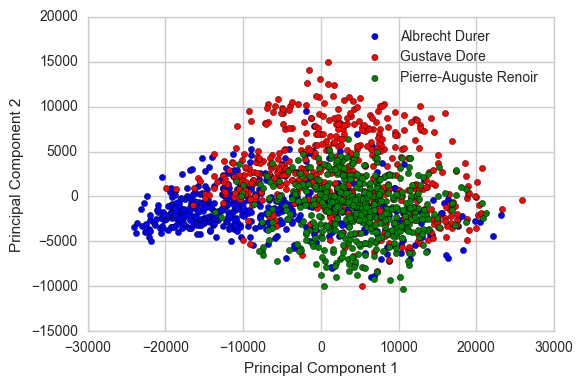

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(("Albrecht Durer ", "Gustave Dore ", "Pierre-Auguste Renoir "), 
                        ('blue', 'red', 'green')):
        plt.scatter(X[test_images==lab, 0],
                    X[test_images==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
print("X_train shape:  " + str(X_train.shape))
print("y_train shape:  " + str(y_train.shape))
print("X_test shape:  " + str(X_test.shape))
print("y_test shape:  " + str(y_test.shape))

X_train shape:  (1200, 600)
y_train shape:  (1200,)
X_test shape:  (300, 600)
y_test shape:  (300,)


In [28]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_std = sc_X.fit_transform(X_train)
X_std1 = sc_X.fit_transform(X_test)

In [29]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

C:\Users\Amrita\Anaconda342\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:

classifier = [
    KNeighborsClassifier(2),
    #SVC(kernel='linear', C=0.025),
    SVC(kernel='rbf', gamma=2, C=1),
    SVC(kernel='poly', degree=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(criterion='entropy',min_samples_split=10),
    RandomForestClassifier(max_depth=5,n_estimators=10,max_features=1),
    AdaBoostClassifier(),
    GaussianNB()]

for clf in classifier:
    clf.fit(X_std, y_train)
    pred=clf.predict(X_std1)
    print(" Accuracy_score:: " + str(accuracy_score(y_test,pred)))

 Accuracy_score:: 0.363333333333
 Accuracy_score:: 0.286666666667
 Accuracy_score:: 0.37
 Accuracy_score:: 0.72
 Accuracy_score:: 0.656666666667
 Accuracy_score:: 0.52
 Accuracy_score:: 0.726666666667
 Accuracy_score:: 0.53


In [31]:
clf=AdaBoostClassifier()
clf.fit(X_std, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

# Evaluating the model

When we make predictions on our holdout set, we find the the classifier performs well.

In [32]:
pd.crosstab(y_test, clf.predict(X_std1), rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2
Actual,,,
0,68,12,24
1,11,65,10
2,14,11,85


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(classification_report(y_test, clf.predict(X_std1)))

             precision    recall  f1-score   support

          0       0.73      0.65      0.69       104
          1       0.74      0.76      0.75        86
          2       0.71      0.77      0.74       110

avg / total       0.73      0.73      0.73       300



In [ ]:
#Parameter Tuning

In [35]:
#Gridsearch: Hyperparameter Optimization with Adaboost classifier
n_estimators_values = np.arange(10,100,10)
learning_rate_values = np.arange(0.1,10,.1)

best_score = 0  
best_params = {'n_estimators': None, 'learning_rate': None}

for n in n_estimators_values:  
    for lrn in learning_rate_values:
        clf=AdaBoostClassifier(n_estimators=n, learning_rate=lrn)
        clf.fit(X_std, y_train)
        score = clf.score(X_std1, y_test)

        if score > best_score:
            best_score = score
            best_params['n_estimators'] = n
            best_params['learning_rate'] = lrn

best_score, best_params

(0.79000000000000004,
 {'learning_rate': 0.20000000000000001, 'n_estimators': 80})

In [36]:
#Gridsearch: Hyperparameter Optimization for DecisionTree Classifier
from sklearn.model_selection import GridSearchCV

param_grid={'max_depth': np.arange(1,50)}

tree=DecisionTreeClassifier()
tree_cv = GridSearchCV(tree,param_grid,cv=5)
tree_cv.fit(X_std, y_train)

print(tree_cv.best_params_)
print(tree_cv.best_score_)

{'max_depth': 11}
0.700833333333


In [37]:
#Hyperparameter tuning with Support Vector Mahine Classifier

from sklearn.model_selection import GridSearchCV

param_grid={'C': np.arange(1,50)}
svc=SVC(kernel='poly', degree=2)
svc_cv = GridSearchCV(svc,param_grid,cv=5)
svc_cv.fit(X_std, y_train)

print(svc_cv.best_params_)
print(svc_cv.best_score_)

{'C': 3}
0.4875


In [38]:
clf=AdaBoostClassifier(learning_rate=0.2, n_estimators=80)
clf.fit(X_std, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=80, random_state=None)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, clf.predict(X_std1)))

             precision    recall  f1-score   support

          0       0.79      0.62      0.69       104
          1       0.82      0.85      0.83        86
          2       0.77      0.91      0.83       110

avg / total       0.79      0.79      0.78       300



So we are getting best accuracy score 79% with adaboost classifier for 3 arist having 1500 paintings only.